<a href="https://colab.research.google.com/github/kshreyas20/Datascience/blob/master/Assignment_3_coronavirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

In [0]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [0]:
data_dir = Path('/content/drive/My Drive/corona/covid19-detection-xray-dataset')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'TrainData'

# Path to validation directory
val_dir = data_dir / 'ValData'

# Path to test directory
#test_dir = data_dir / 'test'

In [34]:
# Get the path to the normal and pneumonia sub-directories
Normal_cases_dir = train_dir / 'Normal'
BacterialPneumonia_cases_dir = train_dir / 'BacterialPneumonia'
ViralPneumonia_cases_dir = train_dir / 'ViralPneumonia'
COVID_19_cases_dir = train_dir / 'COVID-19'
# Get the list of all the images
Normal_cases = Normal_cases_dir.glob('*.jpeg')
BacterialPneumonia_cases_cases = BacterialPneumonia_cases_dir.glob('*.jpeg')
ViralPneumonia_cases = ViralPneumonia_cases_dir.glob('*.jpeg')
COVID_19_cases = COVID_19_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in Normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in BacterialPneumonia_cases_cases:
    train_data.append((img, 1))

for img in ViralPneumonia_cases:
    train_data.append((img,2))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in COVID_19_cases:
    train_data.append((img, 3))


# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/drive/My Drive/corona/covid19-detecti...,2
1,/content/drive/My Drive/corona/covid19-detecti...,1
2,/content/drive/My Drive/corona/covid19-detecti...,2
3,/content/drive/My Drive/corona/covid19-detecti...,0
4,/content/drive/My Drive/corona/covid19-detecti...,1


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 2 columns):
image    2001 non-null object
label    2001 non-null int64
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [36]:
train_data[train_data.label == 3].count()

image    50
label    50
dtype: int64

0    900
1    640
2    411
3     50
Name: label, dtype: int64


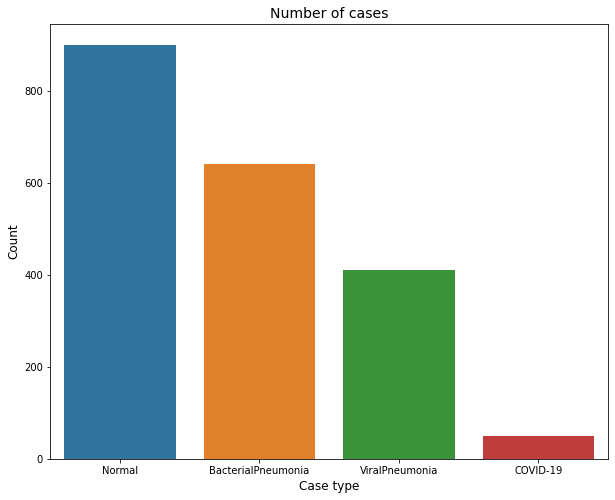

In [37]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal', 'BacterialPneumonia','ViralPneumonia','COVID-19'])
plt.show()

20


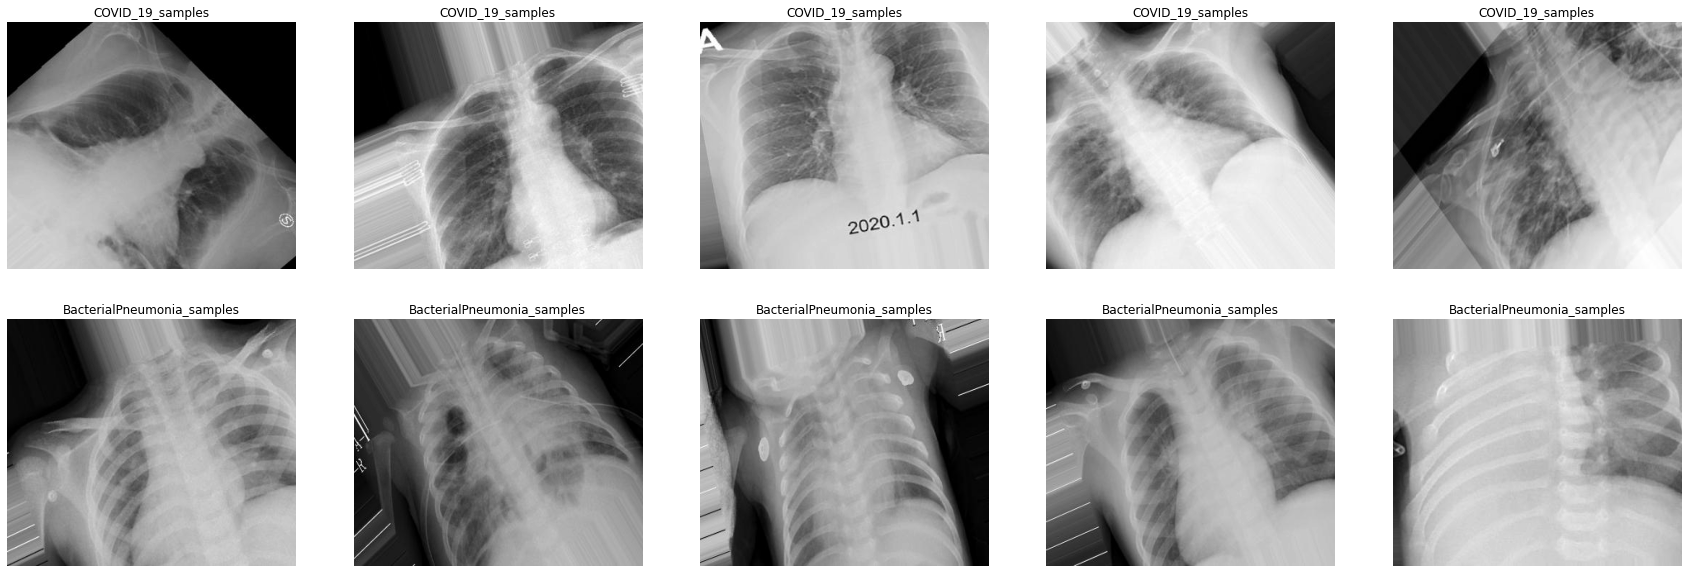

In [19]:
# Get few samples for both the classes
COVID_19_samples = (train_data[train_data['label']==3]['image'].iloc[:5]).tolist()
BacterialPneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
ViralPneumonia_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
#samples = COVID_19_samples+ViralPneumonia_samples+BacterialPneumonia_samples+normal_samples
#del BacterialPneumonia_samples,ViralPneumonia_samples,COVID_19_samples, normal_samples
print(len(samples))
# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(20):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("COVID_19_samples")
    elif i < 10:
        ax[i//5, i%5].set_title("ViralPneumonia_samples")
    elif i < 15:
        ax[i//5, i%5].set_title("BacterialPneumonia_samples")  
    else :
        ax[i//5, i%5].set_title("Normal") 
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

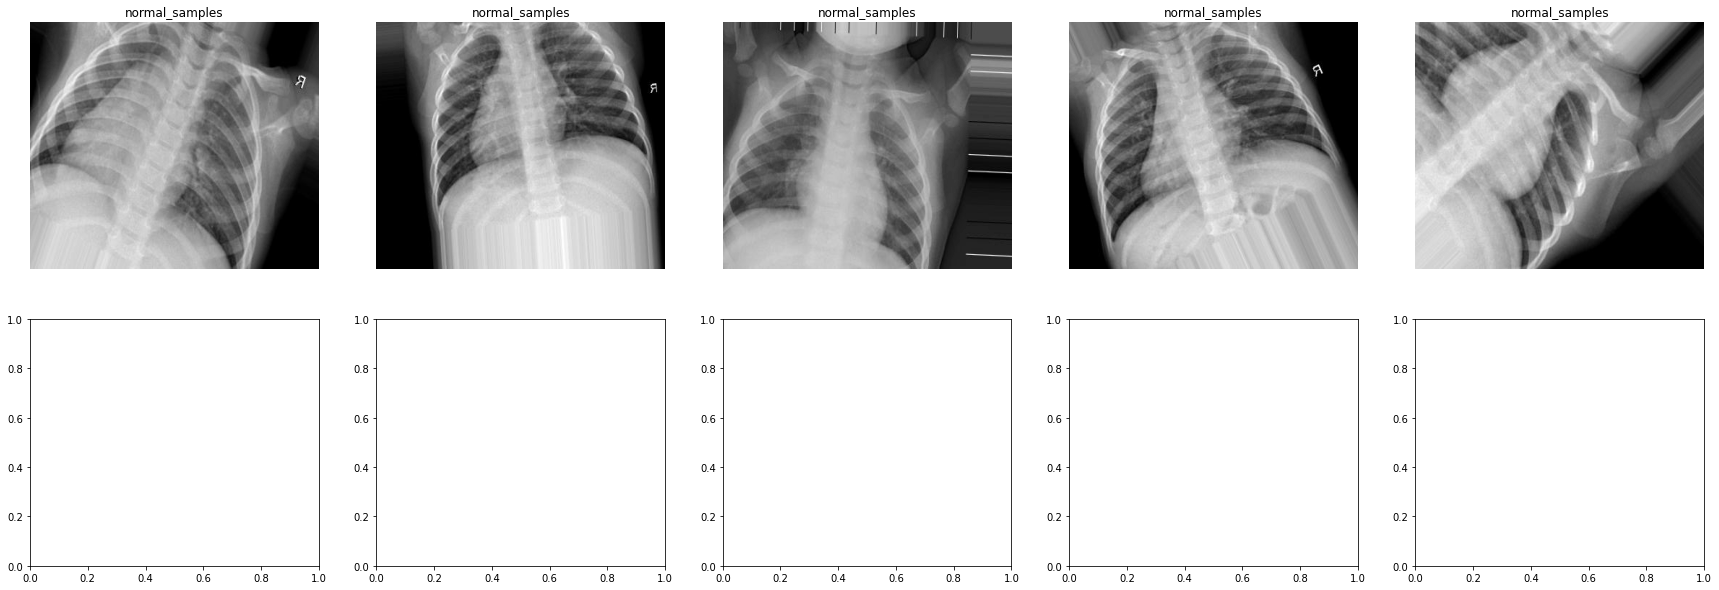

In [22]:
# Get few samples for both the classes
COVID_19_samples = (train_data[train_data['label']==3]['image'].iloc[:5]).tolist()
BacterialPneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
ViralPneumonia_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
#samples = COVID_19_samples+ViralPneumonia_samples+BacterialPneumonia_samples+normal_samples
#del BacterialPneumonia_samples,ViralPneumonia_samples,COVID_19_samples, normal_samples
# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(5):
    img = imread(COVID_19_samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    ax[i//5, i%5].set_title("COVID_19_samples") 
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
for i in range(5):
    img = imread(BacterialPneumonia_samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    ax[i//5, i%5].set_title("BacterialPneumonia_samples") 
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
for i in range(5):
    img = imread(ViralPneumonia_samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    ax[i//5, i%5].set_title("ViralPneumonia_samples") 
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
for i in range(5):
    img = imread(normal_samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    ax[i//5, i%5].set_title("normal_samples") 
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution


https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynb